# Import

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import glob, os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)
import random
import cv2

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

tqdm.pandas()
#import plotly.express as px
#import plotly.graph_objects as go
#import plotly.figure_factory as ff
#from plotly.subplots import make_subplots

#pip install torchsummary
from torchsummary import summary

C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\tqdm\std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Check localization of data

In [2]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


In [3]:
data_dir = ''

In [4]:
# Verification of the number of Images 

# load filenames for human and dog images
size = 0
size = np.array(glob(data_dir+"images/*"))

# Check one image
#Image.open(open("/kaggle/input/plant-pathology-2020-fgvc7/images/Train_3.jpg", 'rb'))

# print number of images in each dataset
print('There are %d total images.' % len(size))

sample_csv = pd.read_csv(data_dir + 'sample_submission.csv')
test_csv = pd.read_csv(data_dir + 'test.csv')
train_csv = pd.read_csv(data_dir + 'train.csv')

train_csv

There are 3642 total images.


image_id  healthy  multiple_diseases  rust  scab
0        Train_0        0                  0     0     1
1        Train_1        0                  1     0     0
2        Train_2        1                  0     0     0
3        Train_3        0                  0     1     0
4        Train_4        1                  0     0     0
...          ...      ...                ...   ...   ...
1816  Train_1816        0                  0     0     1
1817  Train_1817        1                  0     0     0
1818  Train_1818        1                  0     0     0
1819  Train_1819        0                  0     1     0
1820  Train_1820        0                  0     0     1

[1821 rows x 5 columns]

# Channel Distribution


In [5]:
SAMPLE_LEN = 100
IMAGE_PATH = data_dir + 'images/'

def load_image(image_id):
    file_path = image_id + ".jpg"
    #print(file_path)
    image = cv2.imread(IMAGE_PATH + file_path)
    #print(image)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_images = train_csv["image_id"][:SAMPLE_LEN].progress_apply(load_image)



100%|██████████| 100/100 [00:08<00:00, 11.65it/s]


<Figure size 432x288 with 0 Axes>

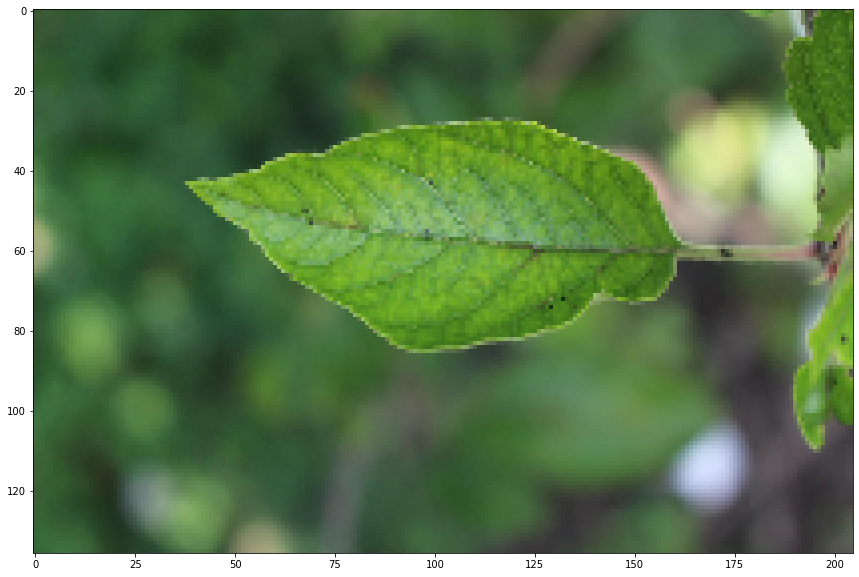

In [6]:

fig_one = plt.figure()
fig_one = plt.figure(figsize=(50,10))
ax_show = fig_one.add_subplot(111)
ax_show.imshow(cv2.resize(train_images[9], (205, 136)))


# Channel distribution

In [7]:
red_values = [np.mean(train_images[idx][:, :, 0]) for idx in range(len(train_images))]
green_values = [np.mean(train_images[idx][:, :, 1]) for idx in range(len(train_images))]
blue_values = [np.mean(train_images[idx][:, :, 2]) for idx in range(len(train_images))]
values = [np.mean(train_images[idx]) for idx in range(len(train_images))]


## All channel value

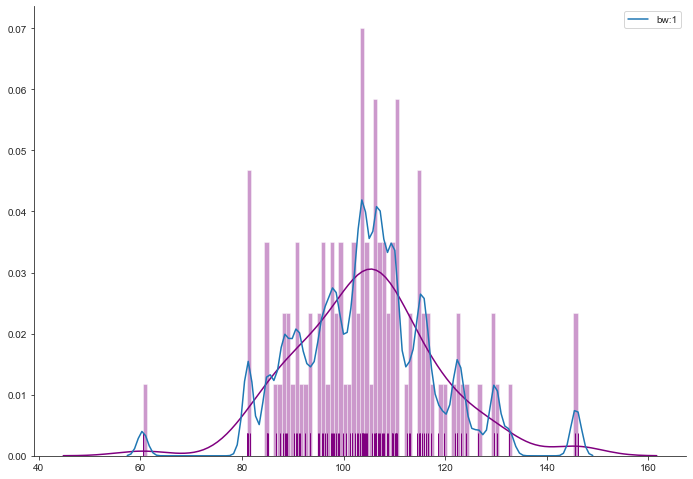

In [8]:
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

sns.distplot(values, bins=100, kde=True, rug=True, color="purple")
sns.kdeplot(values, bw=1, label="bw:1")
#sns.kdeplot(values, bw=2, label="bw:2" )

sns.despine()

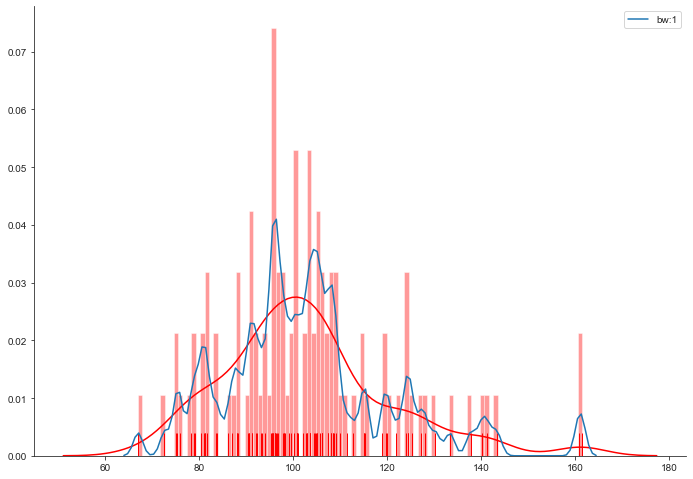

In [9]:
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

sns.distplot(red_values, bins=100, kde=True, rug=True, color="red")
sns.kdeplot(red_values, bw=1, label="bw:1")

sns.despine()

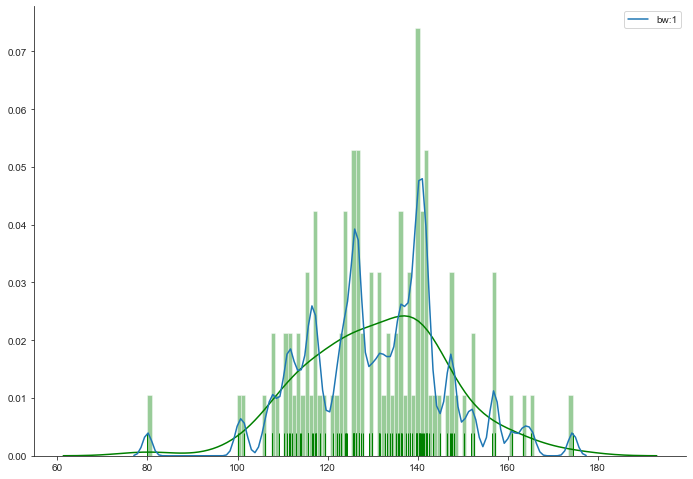

In [10]:
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

sns.distplot(green_values, bins=100, kde=True, rug=True, color="green")
sns.kdeplot(green_values, bw=1, label="bw:1")

sns.despine()

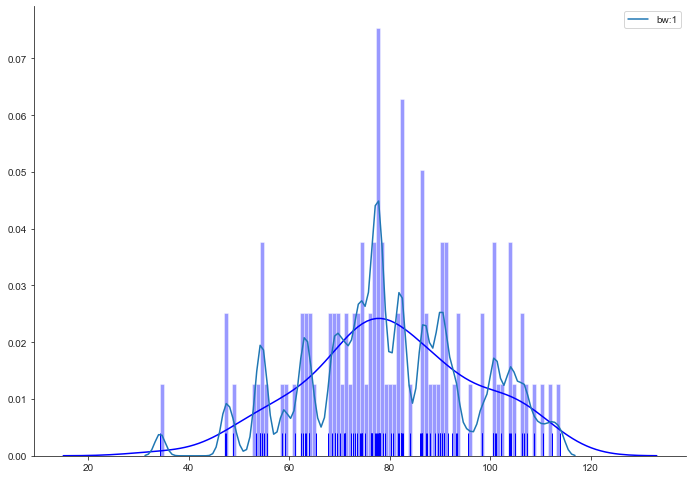

In [11]:
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

sns.distplot(blue_values, bins=100, kde=True, rug=True, color="blue")
sns.kdeplot(blue_values, bw=1, label="bw:1")


sns.despine()

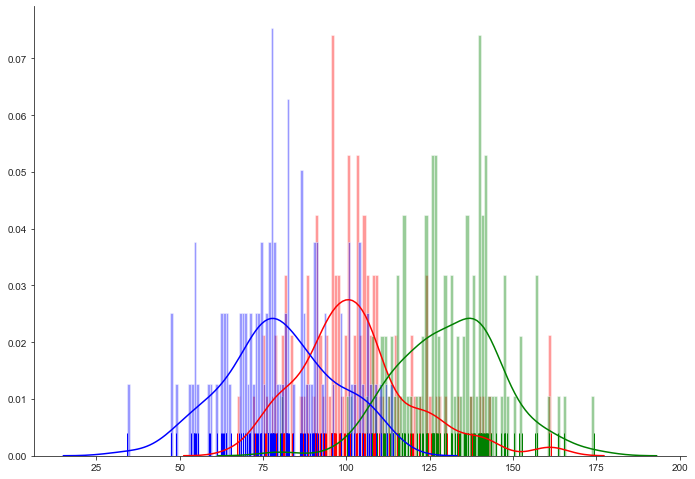

In [12]:
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

sns.distplot(red_values, bins=100, kde=True, rug=True, color="red")
sns.distplot(green_values, bins=100, kde=True, rug=True, color="green")
sns.distplot(blue_values, bins=100, kde=True, rug=True, color="blue")

sns.despine()

## Local standardization


In [13]:
image = Image.open(os.path.join(data_dir+'images/Train_0.jpg'))
pixels = asarray(image)
# convert from integers to floats
pixels = pixels.astype('float32')
# calculate per-channel means and standard deviations
means = pixels.mean(axis=(0,1), dtype='float64')
stds = pixels.std(axis=(0,1), dtype='float64')
print('Means: %s, Stds: %s' % (means, stds))
# per-channel standardization of pixels
pixels = (pixels - means) / stds
# confirm it had the desired effect
means = pixels.mean(axis=(0,1), dtype='float64')
stds = pixels.std(axis=(0,1), dtype='float64')
print('Means: %s, Stds: %s' % (means, stds))

NameError: name 'asarray' is not defined

# Creation of custom datasheet

In [214]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, id_col, target_col, root_dir, sufix=None, transform=None):
        """
        Args:
            csv_file   (string):             Path to the csv file with annotations.
            root_dir   (string):             Directory with all the images.
            id_col     (string):             csv id column name.
            target_col (string):             csv target column name.
            sufix      (string, optional):   Optional sufix for samples.
            transform  (callable, optional): Optional transform to be applied on a sample.
        """
        self.data      = pd.read_csv(csv_file)
        self.id        = id_col
        self.target    = target_col
        self.root      = root_dir
        self.sufix     = sufix
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get the image name at the different idx
        img_name = self.data.loc[idx, self.id]
        
        # if there is not sufic, nothing happened. in this case sufix is '.jpg'
        if self.sufix is not None:
            img_name = img_name + self.sufix
        
        # it opens the image of the img_name at the specific idx
        image = Image.open(os.path.join(self.root, img_name))
        
        # if there is not transform nothing happens, here we defined below two transforms for train and for 
        # image collection via CV2
    
        image_cv2 = cv2.imread(os.path.join(self.root, img_name), cv2.IMREAD_COLOR)
        
        image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
        
        
        if self.transform is not None:
            transformed = self.transform(image=image_cv2)
            image_cv2 = transformed['image']
            
        # define the label based on the idx
        if self.transform == train_transforms or self.transform == valid_transforms:
            label_target = self.data.iloc[idx, 1:5].values.astype('int64')
            label_target = np.argwhere(label_target ==1)
            label_target = label_target.item(0)
            label_target = torch.tensor(label_target)
            #print(label_target)
        else:
            label_target = torch.tensor(0)
        
        # Label of the data
        if self.transform == train_transforms or self.transform == valid_transforms:
            label = self.data.loc[idx, self.id]
            label = int(label[6:])
            label = torch.tensor(label)
        else:
            label = self.data.loc[idx, self.id]
            #print(label)
            label = int(label[5:])
            label = torch.tensor(label)
        
        return image_cv2, label_target, label
'''    
train_transforms = transforms.Compose([
        transforms.RandomRotation(45),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.ToTensor()  
])

train_transforms = A.Compose([
    A.RandomResizedCrop(height=400, width=400, p=1.0),
    A.Flip(),
    A.ShiftScaleRotate(rotate_limit=1.0, p=0.8),
    A.OneOf([
        A.IAAEmboss(p=1.0),
        A.IAASharpen(p=1.0),
        A.Blur(p=1.0),
    ], p=0.5),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0)
])

'''
train_transforms = A.Compose([
    A.Resize(height=550, width=550, p=1.0),
    RandomRotate90(),
    Flip(),
    Transpose(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(p=1.0),
    ], p=0.3),
    HueSaturationValue(p=0.3),
    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    #A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(p=1.0),
], p=1.0)
 
valid_transforms = A.Compose([
    A.Resize(height=550, width=550, p=1.0), 
    A.Normalize(p=1.0), 
    ToTensorV2(p=1.0)
])
    
test_transforms = A.Compose([
    A.Resize(height=550, width=550, p=1.0), 
    A.Normalize(p=1.0), 
    ToTensorV2(p=1.0)
])


params = {
    'id_col':     'image_id',  
    'target_col': ['healthy', 'multiple_diseases', 'rust', 'scab'],
    'sufix':      '.jpg',
}



In [215]:
image_dataset = {x: CustomDataset(csv_file=data_dir+'train.csv', 
                                   root_dir=data_dir+'images', 
                                   **params,
                                   transform=train_transforms if x == 'train' 
                                            else valid_transforms if x == 'valid' 
                                            else test_transforms) 
                 for x in ['train', 'valid', 'test']}
data_loader = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size = 4,  shuffle=True) 
               for x in ['train', 'valid', 'test']}

print('TRAINING')
img, lab_target, lab = image_dataset['train'].__getitem__(0)

print('DATASET')
print('image at the first row: ', img.shape)
print('image size at the first row: {}'.format(img.shape))
print('\nTarget at the first row: ', lab_target)
print('Target format at the first row: {}'.format(lab_target))
print('Target format at the first row: {}'.format(lab_target.shape))
print('\nLab at the first row: ', lab)
print('lab format at the first row: {}'.format(lab))
print('lab format at the first row: {}'.format(lab.shape))


print()
print('Train Loader type')
train_iter = iter(data_loader['train'])
print(type(train_iter))

images, labels_target, labels = train_iter.next()
print()
print('DATALOADER')
print('images type on batch size = {}'.format(type(images)))
print('images shape on batch size = ', images.shape)
print('\nTaregt type on batch size = {}'.format(labels_target))
print('Target type on batch size = {}'.format(type(labels_target)))
print('Target shape on batch size = ', labels_target.shape)
print('\nlabels type on batch size = {}'.format(labels))
print('labels type on batch size = {}'.format(type(labels)))
print('labels shape on batch size = ', labels.shape)



TRAINING
DATASET
image at the first row:  torch.Size([3, 550, 550])
image size at the first row: torch.Size([3, 550, 550])

Target at the first row:  tensor(3)
Target format at the first row: 3
Target format at the first row: torch.Size([])

Lab at the first row:  tensor(0)
lab format at the first row: 0
lab format at the first row: torch.Size([])

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>

DATALOADER
images type on batch size = <class 'torch.Tensor'>
images shape on batch size =  torch.Size([4, 3, 550, 550])

Taregt type on batch size = tensor([2, 2, 3, 3])
Target type on batch size = <class 'torch.Tensor'>
Target shape on batch size =  torch.Size([4])

labels type on batch size = tensor([294, 821, 751, 217])
labels type on batch size = <class 'torch.Tensor'>
labels shape on batch size =  torch.Size([4])


## Dataset Visualization

# tranform impact on image

1. the image 1346 target is scab
2. the image 1526 target is multiple_diseases
3. the image 1064 target is rust
4. the image 907 target is healthy


<Figure size 432x288 with 0 Axes>

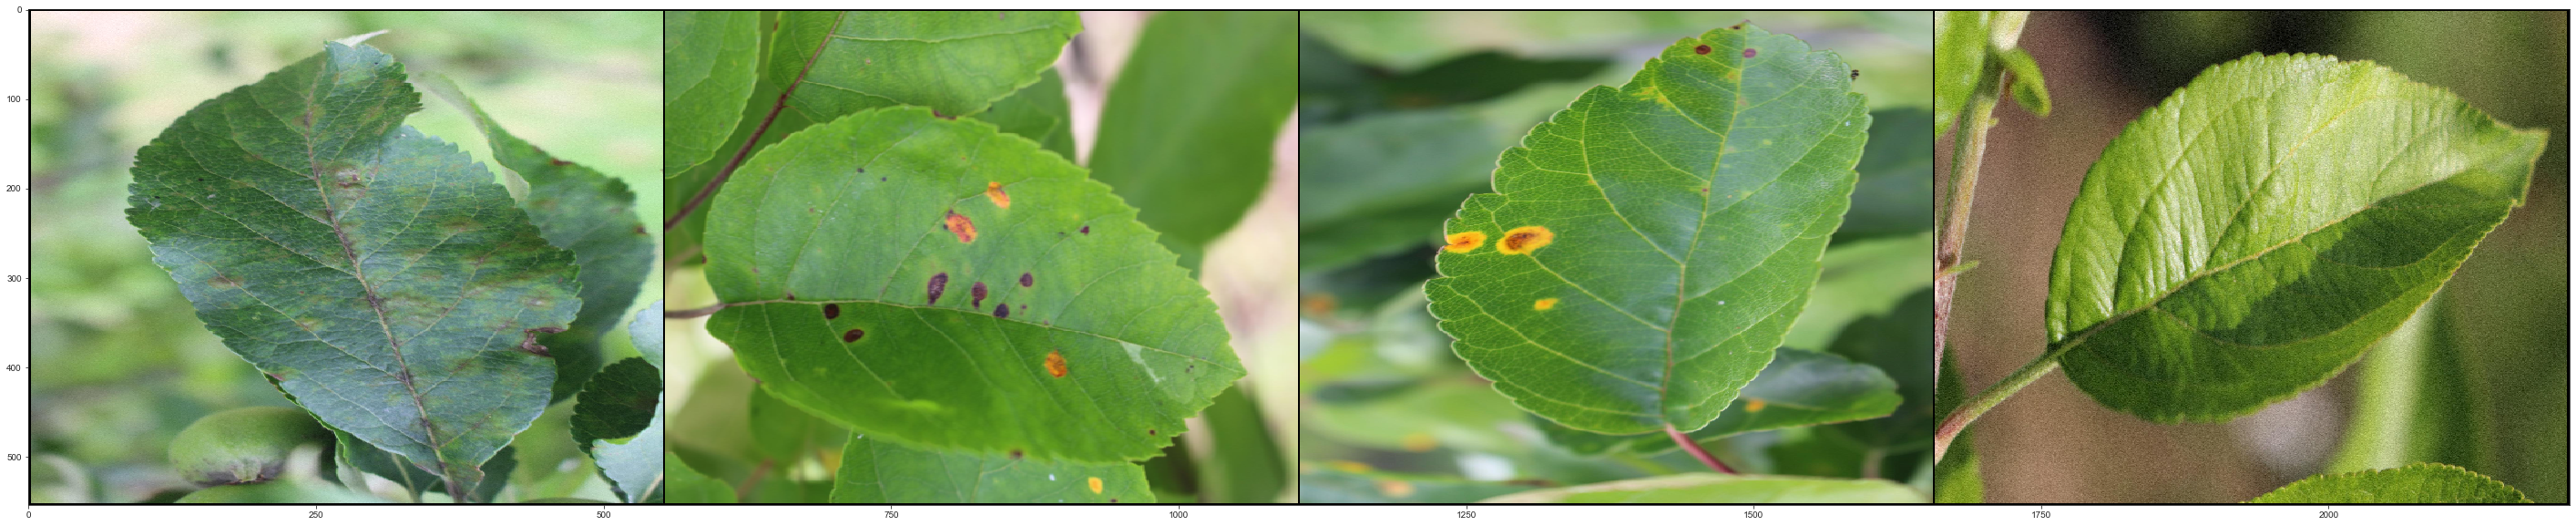

<Figure size 432x288 with 0 Axes>

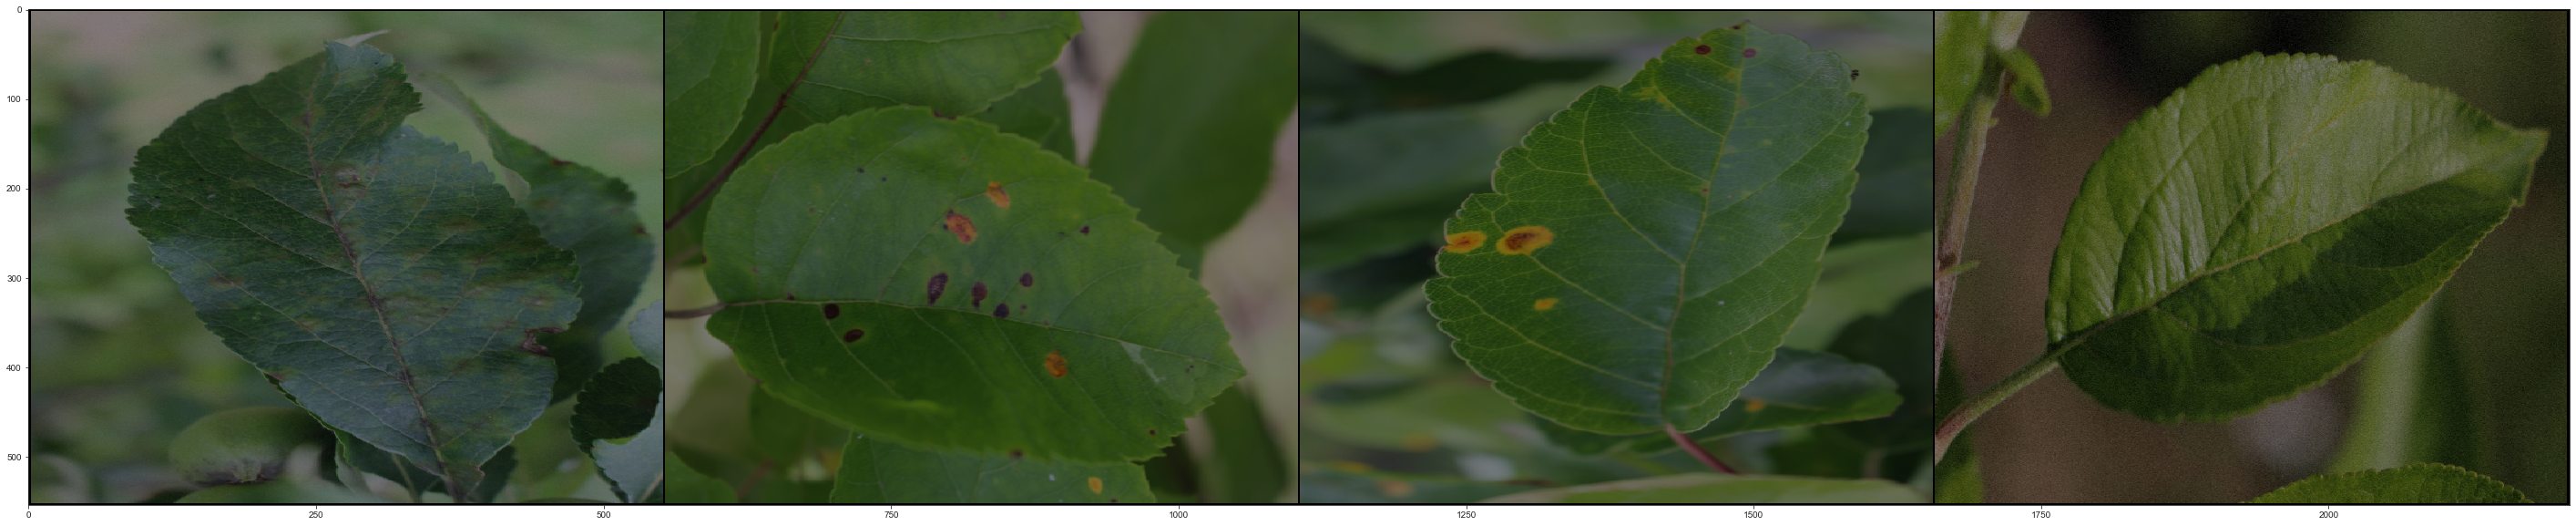

In [216]:
classes = ('healthy', 'multiple_diseases', 'rust', 'scab')

dataiter_test = iter(data_loader['train'])
#print('data_iter\n',dataiter_test)
images_test = dataiter_test.next()
images_test_data = images_test[0]
#print('image test data',images_test_data)
images_target_label = images_test[1]
#print(len(images_target_label))
images_label = images_test[2]
#print(len(images_label))

for i in range(len(images_target_label)):
    print('{}. the image {} target is {}'.format(i+1,images_label[i].numpy(), classes[images_target_label[i].numpy()]))

def imshow(img):
    # image from transform
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure()
    fig = plt.figure(figsize=(50,10))
    ax_show = fig.add_subplot(111)
    ax_show.imshow(np.transpose(npimg, (1, 2, 0)), aspect = 'auto', interpolation='none')
    plt.show()
    
    # image unormalize
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure()
    fig = plt.figure(figsize=(50,10))
    ax_show = fig.add_subplot(111)
    ax_show.imshow(np.transpose(npimg, (1, 2, 0)), aspect = 'auto', interpolation='none')
    plt.show()

# print images
imshow(torchvision.utils.make_grid(images_test_data))

# Model

In [217]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # CL sees 224 x 224 x 3 image tensor
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv11= nn.Conv2d(16, 16, 2, padding=0)
        self.conv1_1 = nn.Conv2d(16, 32, 3, padding=1)
        
        # CL sees 112 x 112 x 16
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv22 = nn.Conv2d(64, 64, 2, padding=0)
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        
        
        # CL sees 56 x 56 x 32
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv33 = nn.Conv2d(256, 256, 2, padding=0)
        self.conv3_1 = nn.Conv2d(256, 512, 3, padding=1)
        
        
        # CL sees 56 x 56 x 32
        self.conv4 = nn.Conv2d(512, 512, 2, padding=0)
        self.conv4_1 = nn.Conv2d(512, 1024, 3, padding=1)
        self.batchnorm512 = nn.BatchNorm2d(1024)
        
        #batchNorm
        self.batchnorm16 = nn.BatchNorm2d(16)
        self.batchnorm32 = nn.BatchNorm2d(32)
        self.batchnorm64 = nn.BatchNorm2d(64)
        self.batchnorm128 = nn.BatchNorm2d(128)
        self.batchnorm256 = nn.BatchNorm2d(256)
        self.batchnorm512 = nn.BatchNorm2d(512)
        self.batchnorm1024 = nn.BatchNorm2d(1024)
        #self.batchnorm2048 = nn.BatchNorm2d(2048)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(3, 3)
        self.AVGpool = nn.AvgPool2d(3, 3)
        
        # linear layer (64 * 28 * 28 -> 500)
        self.fc1 = nn.Linear(1024 * 19 * 19, 500)
        
        # linear layer (500 -> 250)
        self.fc2 = nn.Linear(500, 250)
        
        # linear layer (250 -> 125)
        self.fc3 = nn.Linear(250, 125)
        
        # linear layer (250 -> 4)
        self.fc4 = nn.Linear(125, 4)
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout2d(0.2)
        
        # LogSoftmax
        self.LogSM = nn.LogSoftmax()
    
    def forward(self, x):
        ## Define forward behavior
        # 1st CNN
        # 3 => 16
        x = self.conv1(x)
        x = F.relu6(x)
        x = self.conv11(x)
        x = F.relu6(x)
        x = self.batchnorm16(x)
        
        # 16 => 32
        x = self.conv1_1(x)
        x = F.relu6(x)
        x = self.batchnorm32(x)
        
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        # 2nd CNN
        # 32 => 64
        x = self.conv2(x)
        x = F.relu6(x)
        x = self.conv22(x)
        x = F.relu6(x)
        x = self.batchnorm64(x)
        
        # 64 => 128
        x = self.conv2_1(x)
        x = F.relu6(x)
        x = self.batchnorm128(x)
        
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        # 3rd CNN
        # 128 => 256
        x = self.conv3(x)
        x = F.relu6(x)
        x = self.conv33(x)
        x = F.relu6(x)
        x = self.batchnorm256(x)

        # 256 => 512
        x = self.conv3_1(x)
        x = F.relu6(x)
        x = self.batchnorm512(x)
        
        # 512 => 1024
        x = self.conv4(x)
        x = F.relu6(x)
        x = self.conv4_1(x)
        x = self.batchnorm1024(x)
        
        x = self.AVGpool(x)
        x = self.dropout(x)
       
        # flatten image input
        print(x.shape)
        x = x.view(-1, 1024 * 19 * 19)
        #x = self.dropout(x)
        
        # add 1st hidden layer, with relu activation function
        x = self.fc1(x)
        x = F.relu6(x)
        x = self.dropout(x)
        
        #h2
        x = self.fc2(x)
        x = F.relu6(x)
        x = self.dropout(x)
        
        #h3
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        #h
        x = self.LogSM(self.fc4(x))

        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_patho = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_patho.cuda()


In [218]:
summary(Net(),input_size=(3, 550, 550))

torch.Size([2, 1024, 19, 19])


C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:138: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 550, 550]             448
            Conv2d-2         [-1, 16, 549, 549]           1,040
       BatchNorm2d-3         [-1, 16, 549, 549]              32
            Conv2d-4         [-1, 32, 549, 549]           4,640
       BatchNorm2d-5         [-1, 32, 549, 549]              64
         AvgPool2d-6         [-1, 32, 183, 183]               0
         Dropout2d-7         [-1, 32, 183, 183]               0
            Conv2d-8         [-1, 64, 183, 183]          18,496
            Conv2d-9         [-1, 64, 182, 182]          16,448
      BatchNorm2d-10         [-1, 64, 182, 182]             128
           Conv2d-11        [-1, 128, 182, 182]          73,856
      BatchNorm2d-12        [-1, 128, 182, 182]             256
        AvgPool2d-13          [-1, 128, 60, 60]               0
        Dropout2d-14          [-1, 128,

In [68]:
### TODO: select loss function
criterion = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer = optim.SGD(model_patho.parameters(), lr=0.001)

In [69]:
def train(n_epochs, loaders, model, optimizer, criterion):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    time_start = time.time()
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for idx, (data, target,_) in enumerate(loaders['train']):

            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            #update training loss
            train_loss += loss.item()*data.size(0)
            
        model.eval()
        for idx, (data, target, _) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].sampler)
        valid_loss = valid_loss/len(loaders['valid'].sampler)
        
        # Calcul time
        time_now = time.time()
        
        time_epoch = (time_now - time_start)/60
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTime since the beginning{:.1f} min'.format(
            epoch, 
            train_loss,
            valid_loss,
            time_epoch
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss,
            torch.save(model.state_dict(), 'model_patho_albumentations_LR0001.pt'))
                 )
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [70]:
model_res = train(30, data_loader, model_patho, optimizer, criterion)



RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 198246400 bytes. Buy new RAM!


In [ ]:
model_res = Net()

# load the model that got the best validation accuracy
model_res.load_state_dict(torch.load('model_patho_3Beg_WithValid_32batch_LR00001.pt'))

model_res

# TEST

In [ ]:
image_dataset = {x: CustomDataset(csv_file=data_dir+'test.csv', 
                                   root_dir=data_dir+'images', 
                                   **params,
                                   transform=train_transforms if x == 'train' 
                                            else valid_transforms if x == 'valid' 
                                            else test_transforms) 
                 for x in ['train', 'valid', 'test']}
data_loader = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size = 4,  shuffle=True) 
               for x in ['train', 'valid', 'test']}

print('TRAINING')
img_test, lab_target_test, lab_test = image_dataset['test'].__getitem__(0)

print('DATASET TEST')
print('image at the first row: {}', img_test.shape)
print('image size at the first row: {}'.format(img_test.size()))
print('\nTarget at the first row: ', lab_target_test)
print('Target format at the first row: {}'.format(lab_target_test))
print('Target shape at the first row: {}'.format(lab_target_test.shape))
print('\nLab at the first row: ', lab_test)
print('lab format at the first row: {}'.format(lab_test))
print('lab format at the first row: {}'.format(lab_test.shape))

print()
print('Train Loader type')
test_iter = iter(data_loader['test'])
print(type(test_iter))


images_test, _, labels_test = test_iter.next()
print()
print('DATALOADER TEST')
print('images test',images_test[0][0][0][0])
print('images type on batch size = {}'.format(type(images_test)))
print('images shape on batch size = {}', images_test.shape)
print('\nlabels type on batch size = {}'.format(type(labels_test)))
print('labels shape on batch size = {}', labels_test)

In [ ]:
classes = ('healthy', 'multiple_diseases', 'rust', 'scab')

dataiter_test = iter(data_loader['test'])
print('data_iter\n',dataiter_test)
images_test = dataiter_test.next()
images_test_data = images_test[0]
print('image test data',images_test_data)
images_test_label = images_test[1]
print(images_test_label)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# print images
imshow(torchvision.utils.make_grid(images_test_data))
#print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
model_test = Net()
model_test.load_state_dict(torch.load('model_patho_3Beg_WithValid_32batch_LR00001.pt'))
model_test = model_test.eval()

out_fwd = model_test.forward(images_test_data)
print('Result preditcion model on dataset:\n {}\n'.format(out_fwd))
probs = torch.exp(out_fwd)
print('probs\n', probs)
top_probs, top_labs = probs.topk(4)
print('top_probs:\n {} \n top_labs:\n {}'.format(top_probs, top_labs))
print(classes[top_labs[0][0].detach().numpy()])
print(classes[top_labs[1][0].detach().numpy()])
print(classes[top_labs[2][0].detach().numpy()])
print(classes[top_labs[3][0].detach().numpy()])


# Submission

In [ ]:
submission_df = pd.read_csv(data_dir + 'sample_submission.csv')

submission_df.iloc[:, 1:] = 0

submission_df.head()

In [ ]:
submission_df_test = pd.read_csv(data_dir + 'sample_submission.csv')

model_test = Net()
model_test.load_state_dict(torch.load('model_patho_3Beg_WithValid_32batch_LR00001.pt'))
model_test = model_test.eval()

for idx, (data, _, label) in enumerate(data_loader['test']):
    images_data = data
    #print(images_data)
    label_data = label
    #print(label_data)   
    probs = torch.exp(model_test(images_data))
    #print(probs)
    label_data = label_data.numpy()
    #print(label_data)
    probs = probs.detach().numpy()
    #print(probs)
    for i in range(len(label_data)):
        #print(i)
        ind = label_data[i]
        #print(ind)
        res_probs = probs[i]
        #print(res_probs)
        res_add = ['Test_'+str(ind), res_probs[0], res_probs[1],res_probs[2],res_probs[3]]
        submission_df_test.loc[ind] = res_add         
        
pd.set_option("display.max_rows", 10, "display.max_columns", None)
print(submission_df_test)
submission_df_test.to_csv(path_or_buf='sample_submission_02052020.csv', index=False)
